# SIIM-ISIC Melanoma Classification

This is my solution to the [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification) competition using ResNet34.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
path = Path('../input/siim-isic-melanoma-classification')
path_512 = Path('../input/siim-isic-melanoma-classification-jpeg512')

In order to make it easier to train,we will use [resized images](https://www.kaggle.com/itacdonev/siim-isic-melanoma-classification-jpeg512) (Thank you [stats](https://www.kaggle.com/itacdonev)). Working with the current images in the `jpeg/train` folder, it would take 5 hours to run one complete epoch (See Version 1) because the images are of different sizes and fastai would need to resize each batch on the fly. If the images are resized beforehand, it will take less time to train, meaning we can run more epochs.

In [5]:
np.random.seed(2)
data = ImageDataBunch.from_csv(
            path_512, folder='train512', csv_labels='train.csv', ds_tfms=get_transforms(), label_col=7, size=128, suffix='.jpg', num_workers=0
        ).normalize(imagenet_stats)

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

([0, 1], 2, 26501, 6625)

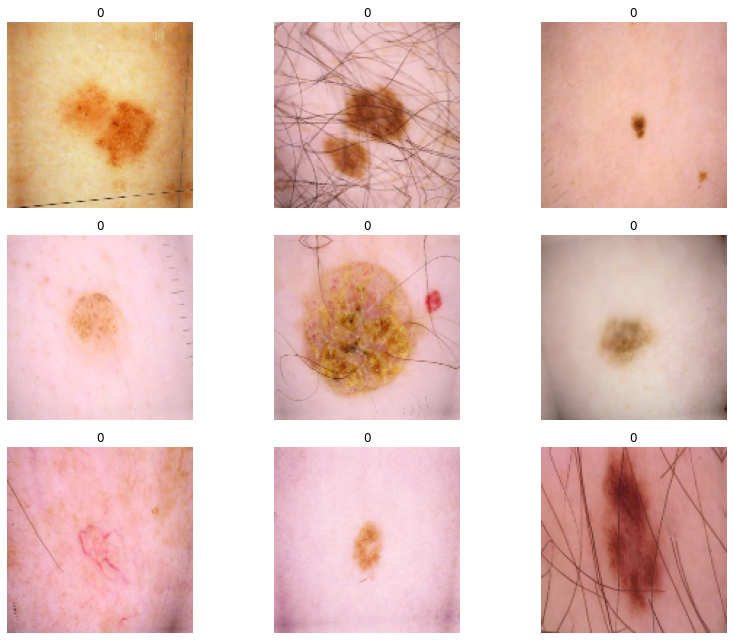

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, AUROC()])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [9]:
lr = 0.01

In [10]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.122153,0.108793,0.022340,0.731650,11:11
1,0.077576,0.087360,0.018264,0.822789,10:26
2,0.077497,0.075748,0.018264,0.850742,10:10
3,0.072266,0.073611,0.018264,0.857585,10:05
4,0.072696,0.072659,0.018113,0.865390,10:25


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [11]:
learn.model_dir = '/kaggle/working'

In [12]:
learn.export('/kaggle/working/export.pkl')

In [13]:
learner = load_learner('/kaggle/working')

In [14]:
img = open_image(path/'jpeg/test/ISIC_0052060.jpg')


pred_class,pred_idx,outputs = learner.predict(img)

# Get the probability of malignancy

prob_malignant = float(outputs[1]) if str(pred_class) == '0' else float(outputs[0])

print(pred_class)
print(prob_malignant)

0
0.0003775641380343586


In [ ]:
test = os.listdir(path/'jpeg/test')
test.sort(key=lambda f: int(re.sub('\D', '', f)))

with open('/kaggle/working/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'target'])
    
    for image_file in test:
        image = os.path.join(path/'jpeg/test', image_file) 
        image_name = Path(image).stem

        img = open_image(image)
        pred_class,pred_idx,outputs = learner.predict(img)
        target = float(outputs[1]) if str(pred_class) == '0' else float(outputs[0])

        
        writer.writerow([image_name, target])